In [1]:
# !pip install torch
# !pip install typing-extensions --upgrade
# !pip install Cython


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import torch 
import torch.nn.functional as F
from torch.autograd.functional import hessian
from torch.distributions.multivariate_normal import MultivariateNormal
import seaborn as sns

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 03: Regressão logística e inferência Bayesiana aproximada

O pedaço de código abaixo carrega o banco de dados 'breast cancer' e adiciona uma coluna de bias. Além disso, ele o particiona em treino e teste.

1. Implemente a estimativa de máximo a posteriori para um modelo de regressão logística com priori $\mathcal{N}(0, c I)$ com $c=100$ usando esse banco de dados;
2. Implemente a aproximação de Laplace para o mesmo modelo;
3. Implemente uma aproximação variacional usando uma Gaussiana diagonal e o truque da reparametrização;
4. Calcule a accuracy no teste para todas as opções acima --- no caso das 2 últimas, a prob predita é $\int_\theta p(y|x, \theta) q(\theta)$;
5. Para cada uma das 3 técnicas, plote um gráfico com a distribuição das entropias para as predições corretas e erradas (separadamente), use a função kdeplot da biblioteca seaborn.
6. Comente os resultados, incluindo uma comparação dos gráficos das entropias.

Explique sua implementação também! 

Para facilitar sua vida: use PyTorch, Adam para otimizar (é uma variação SGD) com lr=0.001, use o banco de treino inteiro ao invés de minibatchces, use binary_cross_entropy_with_logits para implementar a -log verossimilhança, use torch.autograd.functional para calcular a Hessiana. Você pode usar as bibliotecas importadas na primeira célula a vontade. Verifique a documentação de binary_cross_entropy_with_logits para garantir que a sua priori está implementada corretamente, preservando as proporções devidas. Use 10000 amostras das aproximações para calcular suas predições.

In [3]:
data = load_breast_cancer()
N = len(data.data)
Ntrain = int(np.ceil(N*0.6))
perm = np.random.permutation(len(data.data))
X = torch.tensor(data.data).float()
X = torch.cat((X, torch.ones((X.shape[0], 1))), axis=1) 
y = torch.tensor(data.target).float()

Xtrain, ytrain = X[perm[:Ntrain]], y[perm[:Ntrain]]
Xtest, ytest = X[perm[Ntrain:]], y[perm[Ntrain:]]

#### Questão 1

In [4]:
from torch.optim import Adam
from torch.nn.functional import binary_cross_entropy_with_logits
from sklearn.metrics import accuracy_score

n, d = Xtrain.shape
c = 100
learning_rate = 1e-3
epochs = 100000

# p(\theta) = N(0, 100), desv pad = 10
theta = torch.tensor(torch.zeros(d), requires_grad=True)

print('Theta_0: ', theta)
optimizer = torch.optim.Adam([theta], learning_rate, maximize=True)

# Mínimos Quadrados Lineares (Linear Least Squares)
lls = []

for epoch in range(epochs):
    optimizer.zero_grad()
    logits = Xtrain @ theta
    # Calculo da Sigmoide
    softmax = torch.sigmoid(logits)
    # log p(\theta | y) = \sum_i y_i log(\sigma(\theta^T x_i)) + (1 - y_i) log(1 - \sigma(\theta^T x_i) ~ Bernoulli(D | \theta)
    log_likelihood = -F.binary_cross_entropy_with_logits(logits, ytrain)
    # Log Verossimilhança da Dist. de Bernoulli
    # Log Verossimilhança = torch.sum(ytrain * torch.log(softmax) + (1 - ytrain) * torch.log(1 - softmax))
    if(torch.sum(torch.isnan(log_likelihood)) > 0):
        print('Epoch: ', epoch)
        print('Log_Verossimilhança: ', log_likelihood)
        print('softmax: ', softmax)
        print('y_train: ', ytrain)
        print('Theta: ', theta)
        break
        
    # log p(\theta) = -\frac{1}{2} \theta^T \Sigma^{-1} \theta ~ N(0, \Sigma I)
    log_priori = -torch.sum((theta ** 2) / (2*c))

    log_posteriori = (log_likelihood + log_priori)
        
    # Posteriori = torch.exp(log_posteriori)
    lls.append(log_posteriori.item())
    log_posteriori.backward()

    optimizer.step()
    if torch.norm(theta.grad) < 1e-6:
        break
    theta.grad.zero_()

# Máximo a posteriori de theta
print('Theta final: ',theta)

# Calcula a estimativa MAP de theta

y_pred_1 = torch.sigmoid(Xtest @ theta)
print('Y predito:', y_pred_1)

<ipython-input-4-4c09842d8e7e>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = torch.tensor(torch.zeros(d), requires_grad=True)


Theta_0:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.], requires_grad=True)
Theta final:  tensor([ 0.9993,  0.1203,  0.2047, -0.0141, -0.0428, -0.1797, -0.2492, -0.1188,
        -0.0875, -0.0114,  0.0211,  0.3462,  0.1342, -0.1062, -0.0031, -0.0299,
        -0.0328, -0.0141, -0.0234, -0.0020,  0.9694, -0.2394, -0.2105, -0.0128,
        -0.0769, -0.5337, -0.6588, -0.2376, -0.2656, -0.0504,  0.1744],
       requires_grad=True)
Y predito: tensor([9.8924e-01, 2.3312e-02, 8.1948e-01, 9.8127e-01, 2.1714e-08, 8.9470e-01,
        7.3746e-01, 1.6697e-07, 1.3641e-01, 5.4525e-01, 7.9158e-01, 2.9189e-01,
        8.3167e-01, 9.9621e-01, 9.4186e-02, 3.3923e-05, 2.7359e-25, 5.6467e-04,
        9.9887e-01, 9.7470e-01, 3.6759e-01, 9.9457e-01, 7.3906e-02, 9.6800e-01,
        9.9452e-01, 9.9612e-01, 7.9576e-01, 9.9346e-01, 9.9597e-01, 9.9213e-01,
        5.7782e-01, 9.8141e-01, 9.9270e-01, 9.8528e-01, 9.9780e-0

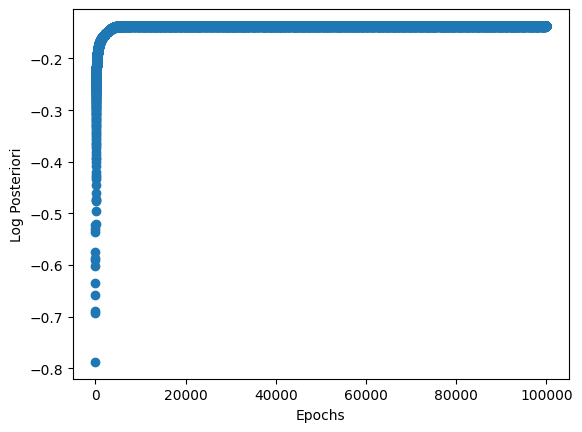

In [5]:
# plot the loss against epochs using scatter plot
plt.scatter(range(len(lls)), lls)
plt.xlabel('Epochs')
plt.ylabel('Log Posteriori')
plt.show()

#### Questão 2

In [6]:
# Implementa a aproximação de Laplace para a distribuicao posteriori de theta
# \mu: arg max da distribuicao posteriori p(\theta | D)
mu = theta.detach().numpy()
# \Sigma: inversa da matriz hessiana da distribuicao log posteriori
hessiana = hessian(lambda theta: -F.binary_cross_entropy_with_logits(Xtrain @ theta, ytrain) - torch.sum((theta ** 2) / (2*c)), theta).detach().numpy()
sigma = np.linalg.inv(hessiana)

# Gera N amostras da distribuicao posteriori
theta_samples = np.random.multivariate_normal(mu, sigma, 10000)
# Calcula a verossimilanca de cada exemplo
likelihoods = torch.sigmoid(Xtest @ torch.tensor(theta_samples).float().T)
# Calcula a média das verossimilhancas
y_pred_2 = torch.mean(likelihoods, axis=1)

print('Y predito:', y_pred_2)

Y predito: tensor([0.6351, 0.4274, 0.5576, 0.6187, 0.3741, 0.5817, 0.5372, 0.3788, 0.4668,
        0.4973, 0.5369, 0.4754, 0.5668, 0.6397, 0.4305, 0.3811, 0.3977, 0.4116,
        0.6256, 0.6340, 0.4885, 0.6390, 0.4628, 0.6268, 0.6296, 0.6418, 0.5369,
        0.6386, 0.6360, 0.6418, 0.5075, 0.6304, 0.6311, 0.6269, 0.6588, 0.6138,
        0.4172, 0.6484, 0.6449, 0.5964, 0.4713, 0.4584, 0.5612, 0.4071, 0.3792,
        0.4020, 0.3896, 0.4002, 0.3780, 0.5917, 0.5565, 0.3950, 0.6296, 0.5619,
        0.6371, 0.5993, 0.6470, 0.6294, 0.4160, 0.6462, 0.3609, 0.5329, 0.4122,
        0.6484, 0.5601, 0.3837, 0.6052, 0.5406, 0.6318, 0.6547, 0.4230, 0.6158,
        0.6447, 0.5871, 0.6271, 0.3884, 0.3729, 0.6243, 0.6487, 0.3830, 0.3768,
        0.4737, 0.4954, 0.6560, 0.6336, 0.6352, 0.3778, 0.6436, 0.5619, 0.6296,
        0.4239, 0.5639, 0.5500, 0.3791, 0.3917, 0.6141, 0.4523, 0.3700, 0.4608,
        0.5458, 0.5243, 0.5384, 0.6231, 0.6341, 0.6294, 0.3951, 0.6221, 0.6314,
        0.6504, 0.3934, 0.377

<ipython-input-6-1bb2d74963c8>:9: RuntimeWarning: covariance is not positive-semidefinite.
  theta_samples = np.random.multivariate_normal(mu, sigma, 10000)


#### Questão 3

In [7]:
epochs = 1000
mu = torch.randn(d, requires_grad=True) 
param_estimator = torch.randn(1, requires_grad=True) 
learning_rate = 1e-3

optimizer = torch.optim.Adam([mu, param_estimator], learning_rate) # as variaveis que serão otimizadas são mu e o estimador

losses = []
n = 1000 # número de amostras para calcular a média da verossimilhança (10000 levou muito tempo executando)
priori_var = 100 # variância da priori

for epoch in range(epochs):
    optimizer.zero_grad()
    estimator_quad = param_estimator**2 
    
    # \theta^t = epsilon^t * sigma + mu
    # Truque da reparametrizacao
    thetas = torch.randn(n, d) * estimator_quad + mu # amostras de theta

    loss = 0
    
    for t in range(n):
        theta_t = thetas[t, :]
        logits = Xtrain @ theta_t  # logits = X * theta^t
        
        # a cross-entropy binária é o -log da verossimilhança de Bernoulli
        neg_log_likelihood = F.binary_cross_entropy_with_logits(logits, ytrain) # neg_log_likelihood = -log(p(y|X, theta^t))
        log_priori = -0.5 * (theta_t @theta_t )/priori_var # log_priori = log(p(theta^t))
        log_q = -d * estimator_quad.log() - 0.5 * ((theta_t  - mu)@(theta_t - mu))/estimator_quad # log_q = log(q(theta^t))
        
        loss += (neg_log_likelihood - log_priori + log_q)/n # loss = E_{theta^t} [ -log(p(y|X, theta^t)) + log(p(theta^t)) - log(q(theta^t)) ]
        losses.append(loss.detach())
        
    loss.backward()
    optimizer.step()

y_pred_3 = torch.zeros_like(ytest)

# Monte Carlo
for t in range(n):
    thetas = torch.randn(d) * param_estimator**2 + mu
    logits = Xtest @ thetas
    y_pred_3 += torch.sigmoid(logits)

# Calcula a média de y_pred
y_pred_3 = y_pred_3/n

print('Y predito:', y_pred_3)

Y predito: tensor([0.6872, 0.4011, 0.4382, 0.5567, 0.0874, 0.5992, 0.3478, 0.1367, 0.2432,
        0.2284, 0.7040, 0.3690, 0.6759, 0.6469, 0.2545, 0.1393, 0.0114, 0.3133,
        0.6395, 0.5194, 0.4226, 0.7209, 0.2653, 0.6403, 0.9158, 0.9254, 0.5599,
        0.7295, 0.7589, 0.6895, 0.5973, 0.7114, 0.5737, 0.4761, 0.7401, 0.5504,
        0.1326, 0.5750, 0.6905, 0.5842, 0.4094, 0.3826, 0.9039, 0.1326, 0.1879,
        0.1661, 0.1769, 0.2038, 0.0326, 0.4170, 0.4713, 0.0270, 0.4339, 0.5419,
        0.5361, 0.4274, 0.6036, 0.6515, 0.2160, 0.5793, 0.0926, 0.5134, 0.2089,
        0.8218, 0.4436, 0.0260, 0.4526, 0.6310, 0.5828, 0.6278, 0.1798, 0.8026,
        0.5898, 0.4364, 0.5081, 0.0689, 0.1262, 0.5775, 0.6440, 0.0895, 0.0593,
        0.2504, 0.4470, 0.7118, 0.7647, 0.6402, 0.2017, 0.8275, 0.3399, 0.9055,
        0.4937, 0.3667, 0.6365, 0.1387, 0.0933, 0.5258, 0.1303, 0.1031, 0.4589,
        0.4133, 0.6528, 0.4944, 0.9422, 0.6606, 0.4654, 0.0401, 0.9562, 0.6189,
        0.6558, 0.0410, 0.142

#### Questão 4

In [8]:
# Calcula a acurácia da questao 1
accuracy_1 = torch.sum((y_pred_1 > 0.5) == ytest)/len(ytest)
print('Acurácia_Q1: ', accuracy_1)

# Calcula a acurácia da questao 2
accuracy_2 = torch.sum((y_pred_2 > 0.5) == ytest)/len(ytest)
print('Acurácia_Q2: ', accuracy_2)

# Calcula a acurácia da questao 3
accuracy_3 = torch.sum((y_pred_3 > 0.5) == ytest)/len(ytest)
print('Acurácia_Q3: ', accuracy_3)

Acurácia_Q1:  tensor(0.9515)
Acurácia_Q2:  tensor(0.9559)
Acurácia_Q3:  tensor(0.8546)


#### Questão 5

In [9]:
preds = [y_pred_1.detach().numpy(), y_pred_2.detach().numpy(), y_pred_3.detach().numpy()]

# plot the entropy for each y_pred
# split y in correct and incorrect
y_correct_1 = (y_pred_1 > 0.5) == ytest
print('Classificação Questão 1:\n', y_correct_1)

print(' ')

y_correct_2 = (y_pred_2 > 0.5) == ytest
print('Classificação Questão 2:\n', y_correct_2)

print(' ')

y_correct_3 = (y_pred_3 > 0.5) == ytest
print('Classificação Questão 3:\n', y_correct_3)

Classificação Questão 1:
 tensor([ True,  True,  True,  True,  True,  True, False,  True,  True, False,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  T

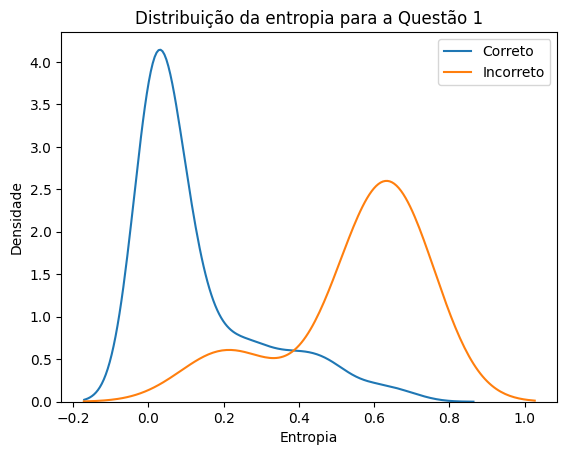

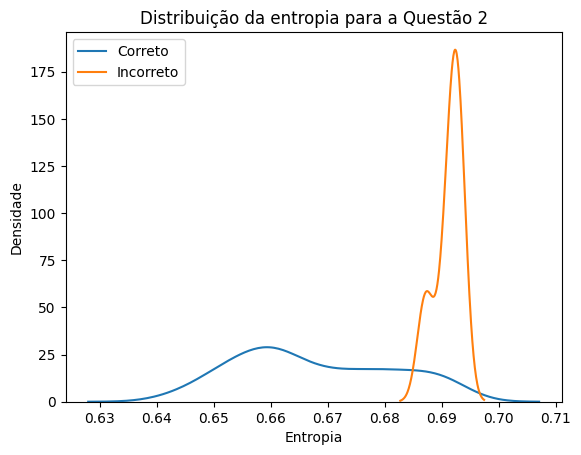

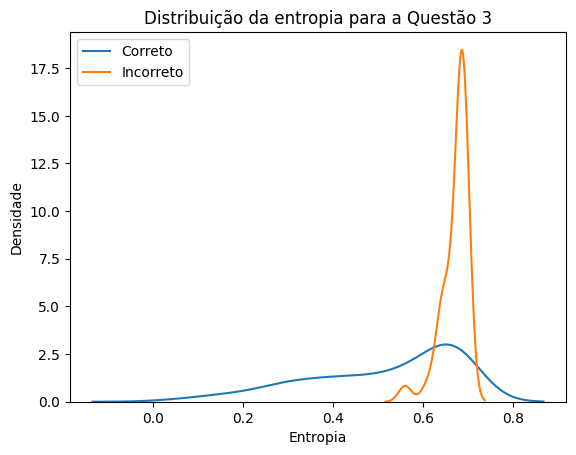

In [10]:
predicoes = [y_pred_1, y_pred_2, y_pred_3]
y_test = ytest

for i in range(3):
    y_pred = predicoes[i]
    
    # Indices de predicoes corretas e incorretas
    index_correto = (y_pred > 0.5) == y_test
    index_incorreto = (y_pred > 0.5) != y_test
    
    # Valores de predicoes corretas e incorretas
    y_pred_correto = y_pred[index_correto]
    y_pred_incorreto = y_pred[index_incorreto]
    
    def log_nan_handler(x):
        # calcula o logaritmo de um tensor de entrada no domínio real, garantindo que não haja valores NaN ou infinitos 
        return torch.log(torch.clamp(x, min=torch.finfo(x.dtype).tiny))

    # Calcula a entropia de predicoes corretas e incorretas
    entropia_correta = -y_pred_correto * log_nan_handler(y_pred_correto) - (1 - y_pred_correto) * log_nan_handler(1 - y_pred_correto)
    entropia_incorreta = -y_pred_incorreto * log_nan_handler(y_pred_incorreto) - (1 - y_pred_incorreto) * log_nan_handler(1 - y_pred_incorreto) 
    
    sns.kdeplot(entropia_correta.detach(), label='Correto')
    sns.kdeplot(entropia_incorreta.detach(), label='Incorreto')
    plt.title(f'Distribuição da entropia para a Questão {i+1}')
    plt.xlabel('Entropia')
    plt.ylabel('Densidade')
    
    # Legend the correct and incorrect predictions
    plt.legend()
    plt.show()


#### Questão 6

Para a questão 1, é possível ver que a implementação da estimativa de máximo a priori foi bem adequada, dada sua acurácia de aproximadamente 95%, ou seja, a escolha da priori foi bem executada. A aproximação de Laplace da questão 2 teve uma acurácia ainda melhor que a implementação direta da priori, ainda que a diferença tenha sido pequena. Isso pode ser dado a não-necessidade de calcular a integral de Bayes. Pode-se notar também que a acurácia da questão 3 foi a menor dentre as implementações. Isso pode ser devido a distribuição variacional utilizada nesse caso.

Dado que a entropia mede o grau de incerteza inerente aos possíveis resultados para uma variável, temos que a incerteza é bem maior para os modelos de aproximação da regressão, já que o valor da moda das entropias é bem maior para as classificações incorretas do que as corretas, com exceção da estimativa de máximo a posteriori não aproximada.

# Exercícios de "papel e caneta"

1. Derive a fórmula para a divergência KL entre duas distribuições Gaussianas univariadas, i.e., $D_\text{KL}\left(\mathcal{N}(\mu_1, \sigma_1^2) \| \mathcal{N}(\mu_2, \sigma_2^2)\right)$;

2. Suponha que $P$ é a família das distribuições categórica com suporte em $\{1,\ldots, L\}$. Qual $p \in P$ possui maior entropia? 

3. Use a desigualdade de Jensen para mostrar que a divergência KL é não-negativa.

4. Derive a aproximação de Laplace para a distribuição Beta($\alpha, \beta$). Mostre uma fórmula para valores genéricos $\alpha,\beta>1$ e a instancie para $\alpha=\beta=2$.

5. Derive a posteriori para o modelo Bayesiano com verossimilhança Categórica e priori Dirichlet, i.e.:
\begin{alignat}{2}
y_1,\ldots, y_N &\sim Cat(\mathbf{\theta})\\
\mathbf{\theta} &\sim Dirichlet(\mathbf{\alpha})
\end{alignat}
onde $\mathbf{\theta}$ e $\mathbf{\alpha}$ são vetores $L$-dimensionais.

### Soluções:

1. 

Temos a seguinte fórmula para a divergência KL:

$$D_{KL} (P||Q) = \mathbb{E}_{x \sim P}\Bigr[\log \dfrac{P(x)}{Q(x)}\Bigr] = \sum P(x)\log \dfrac{P(x)}{Q(x)} = \int P(x)\log \dfrac{P(x)}{Q(x)} dx = -\int P(x)\log Q(x) dx + \int P(x)\log P(x) dx$$

Para derivar a sua fórmula entre duas distribuições Gaussianas univariadas, podemos fazer:

$$\int P(x)\log P(x) dx = -\dfrac{1}{2}(1+\log 2\pi\sigma_1^2) \\
-\int P(x)\log Q(x) dx = -\int P(x)\log \dfrac{1}{(2\pi\sigma_2^2)(1/2)}e^{-\dfrac{(x-\mu_2)^2}{2\sigma_2^2}}dx$$

Agora, podemos separar a equação de $-\int P(x)\log Q(x) dx$ da seguinte maneira:

$$\dfrac{1}{2}\log(2\pi\sigma_2^2) -\int P(x)\log e^{-\dfrac{(x-\mu_2)^2}{2\sigma_2^2}}dx = \dfrac{1}{2}\log(2\pi\sigma_2^2) -\int P(x)\Bigr(-\dfrac{(x-\mu_2)^2}{2\sigma_2^2}\Bigr)dx = \\
= \dfrac{1}{2}\log(2\pi\sigma_2^2) + \dfrac{\int P(x)x^2 dx -\int P(x)2x\mu_2 dx +\int P(x)\mu_2^2 dx}{2\sigma_2^2} = \dfrac{1}{2}\log(2\pi\sigma_2^2) + \dfrac{\sigma_1^2+\mu_1^2-2\mu_1\mu_2+\mu_2^2}{2\sigma_2^2} = \\
= \dfrac{1}{2}\log(2\pi\sigma_2^2) + \dfrac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}$$

Juntando as equações:

$$D_{KL} (P||Q) = -\int P(x)\log Q(x) dx + \int P(x)\log P(x) dx = \dfrac{1}{2}\log(2\pi\sigma_2^2) + \dfrac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}-\dfrac{1}{2}(1+\log 2\pi\sigma_1^2) = \\
= \log \dfrac{\sigma_2}{\sigma_1} + \dfrac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2} -\dfrac{1}{2}$$

KL divergence between two univariate Gaussians (https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians)

KL Divergence between 2 Gaussian Distributions (https://mr-easy.github.io/2020-04-16-kl-divergence-between-2-gaussian-distributions/)

2. 

Temos a seguinte fórmula para a entropia:

$$H(X) = -\sum_{i=1}^nP(x_i)\log P(x_i) $$

Nesse caso, a entropia da distribuição categórica é dada por $H(p_1, \ldots, p_L) = -\sum_{i=1}^L p_i \log p_i$, dado que $\sum_{i=1}^L p_i = 1$ 

Sendo $P$ uma distribuição uniforme discreta, a distribuição de máxima entropia é dada por $p_i = \dfrac{1}{L}, \ i=1, \ldots, L$.

Com isso, calculamos a entropia:

$$H(p) = -\sum_{i=1}^Lp_i \log (p_i) =  -\sum_{i=1}^L\dfrac{1}{L} \log (\dfrac{1}{L}) = L\dfrac{1}{L} \log(L) = \log(L)$$

Maximum entropy probability distribution (https://en.wikipedia.org/wiki/Maximum_entropy_probability_distribution)

Maximum Entropy Distributions (https://bjlkeng.github.io/posts/maximum-entropy-distributions/)

Entropy of a uniform distribution (https://math.stackexchange.com/questions/1156404/entropy-of-a-uniform-distribution)

3. 

Primeiramente, temos que a desigualdade de Jensen é definida como:

$$\mathbb{E}[f(x)] \geq f(\mathbb{E}[x])$$

Temos também que a divergência KL nos diz o quão bem uma distribuição $Q$ aproxima a distribuição $P$ calculando a entropia cruzada menos a entropia:

$$D_{KL} (P||Q) = H(P,Q)-H(P), $$ onde $$H(P,Q) =  \mathbb{E}_{x \sim P}[-\log Q(x)]$$ 
$$H(P) =  \mathbb{E}_{x \sim P}[-\log P(x)]$$

Assim: 
$$D_{KL} (P||Q) = \mathbb{E}_{x \sim P}\Bigr[\log \dfrac{P(x)}{Q(x)}\Bigr] = \sum_x P(x)\Bigr[\log \dfrac{P(x)}{Q(x)}\Bigr]$$

Agora, para mostrar que a divergência é não-negativa, podemos mostrar que $-D_{KL} (P||Q) \leq 0$, e portanto $D_{KL} (P||Q) \geq 0$:

$$-D_{KL} (P||Q) = - \sum_x P(x)\Bigr[\log \dfrac{P(x)}{Q(x)}\Bigr] = \sum_x P(x)\Bigr[\log \dfrac{Q(x)}{P(x)}\Bigr] \leq \sum_x P(x)\Bigr(\dfrac{Q(x)}{P(x)} - 1\Bigr) = \sum_x Q(x) - \sum_x P(x) = 1 -1 = 0$$ 

Tendo isso, concluímos que a divergência KL é não-negativa utilizando a desigualdade de Jensen.


Jensen's inequality (https://en.wikipedia.org/wiki/Jensen's_inequality)

KL Divergence Demystified (https://kikaben.com/kl-divergence-demystified/#:~:text=3.-,The%20KL%20divergence%20is%20non%2Dnegative,%E2%81%A1%20P%20Q%20%3D%20log%20%E2%81%A1&text=if%20P%E2%89%A0Q%2C%20the,minimum%20average%20lossless%20encoding%20size.)

Why KL divergence is non-negative? (https://stats.stackexchange.com/questions/335197/why-kl-divergence-is-non-negative)


4. Queremos encontrar a aproximação $q(\theta)$ para a distribuição Beta, com a seguinte fórmula para $q$:

$$q(\theta) = \mathcal{N}\left(\theta|\mu = m, \Sigma=H^{-1}\right),$$

onde $m = \text{arg max}_{\theta \in \Theta} p(\theta|\mathcal{D})$ e $H = \nabla^2_{\theta}-\log p(\theta|\mathcal{D}) $.

Dado que estamos usando a distribuição Beta, podemos usar de forma direta que a média é igual a moda $m$, que por sua vez é igual a $\dfrac{\alpha-1}{\alpha+\beta-2}$.

Agora, temos $q(x) \propto x^{(\alpha-1)}(1-x)^{(\beta-1)}$, e $\Sigma = H^{-1} = -\dfrac{1}{\dfrac{d^2 \log q(x)}{d x^2}}$

Assim: 

$$\log q(x) = \log(x^{(\alpha-1)}(1-x)^{(\beta-1)}) = \log(x)^{\alpha-1}+\log(x-1)^{\beta-1} = (\alpha-1)\log(x)+(\beta-1)\log(x-1) \Rightarrow  \\
\Rightarrow \dfrac{d \log q(x)}{d x} = (\alpha-1)\dfrac{d \log (x)}{d x} + (\beta-1)\dfrac{d \log (x-1)}{\partial x} = \dfrac{(\alpha-1)}{x}+\dfrac{(\beta-1)}{x-1} \Rightarrow \\
\Rightarrow \dfrac{d^2 \log q(x)}{d x^2} = (\alpha-1)\dfrac{d (1/x)}{d x} + (\beta-1)\dfrac{d (1/(x-1))}{d x} = -\dfrac{(\alpha-1)}{x^2}-\dfrac{(\beta-1)}{(x-1)^2} \Rightarrow \\
\Rightarrow \Sigma=H^{-1} = -\dfrac{1}{\dfrac{(\alpha-1)}{x^2}-\dfrac{(\beta-1)}{(x-1)^2}} = \dfrac{x^2(x-1)^2}{(\alpha-1)(x-1)^2+(\beta-1)x^2}$$

Com isso, devemos ter que $\alpha \neq 1$ e $\beta \neq 1$, e também que a função não terá máximo caso $0<\alpha, \beta<1$ por não ser convexa nesse intervalo. Sendo assim, temos uma fórmula para a distribuição Beta($\alpha, \beta$) para $\alpha, \beta >1$ genéricos.

No caso $\alpha = \beta = 2$:

$$m = \dfrac{\alpha-1}{\alpha+\beta-2} = \dfrac{2-1}{2+2-2} = \dfrac{1}{2} \\
\Sigma = \dfrac{x^2(x-1)^2}{(2-1)(x-1)^2+(2-1)x^2} = \dfrac{x^2(x-1)^2}{(x-1)^2+x^2}$$

Usando $x=m$:

$$\Sigma = \dfrac{(1/2)^2((1/2)-1)^2}{((1/2)-1)^2+(1/2)^2} = \dfrac{(1/4)(1/4)}{(1/4)+(1/4)} = \dfrac{1/16}{1/2}=\dfrac{1}{8}$$

Assim: 

$$Beta(2,2) = \mathcal{N}\left(\theta|\dfrac{1}{2},\dfrac{1}{8}\right)$$
 
Laplace's approximation (https://en.wikipedia.org/wiki/Laplace%27s_approximation)

Beta distribution (https://en.wikipedia.org/wiki/Beta_distribution)

The beta density, Bayes, Laplace, and P´olya (http://www.cs.hunter.cuny.edu/~saad/courses/bayes/notes/note9.pdf) 

5. Primeiramente, temos a distribuição de Dirichlet (Dir($\alpha_1, \ldots, \alpha_k$)):

$$f(x_1, \ldots, x_k;\alpha_1, \ldots, \alpha_k) = \dfrac{\Gamma(\Sigma_{i=1}^k \alpha_i)}{\prod_{i=1}^k \Gamma(\alpha_i)}\prod_{i=1}^k x_i^{\alpha_i-1} $$

Agora, a distribuição Categórica:

$$f(x=i|p) = p_i \\
f(x|p) = \prod_{i=1}^k p_i^{[x=i]}$$

Temos a fórmula da posteriori:

$$f(\theta|D) = \dfrac{f(\theta, D)}{f(D)} \propto f(\theta, D) = f(\theta|\alpha)\prod_{y_i \in D} f(y_i|\theta),$$

onde $D$ é o nosso dataset e $y_i \in D$ são amostras retiradas iid da distribuição $f(y; \theta)$. 

Agora, usando o enunciado:

\begin{alignat}{2}
y_1,\ldots, y_N &\sim Cat(\mathbf{\theta})\\
\mathbf{\theta} &\sim Dirichlet(\mathbf{\alpha})
\end{alignat}

$$f(\theta|D) \propto f(\theta, D) = f(\theta|\alpha)\prod_{y_i \in D}f(y_i|\theta) \\
\propto \prod_{j=1}^N \theta_j^{\alpha_j-1} \prod_{y_i \in D} \prod_{j=1}^N \theta_j^{\large{\mathbb{1}}\{y_i=j\}} = \prod_{j=1}^N \theta_j^{\alpha_j-1+\sum_{y_i \in D} \large{\mathbb{1}}\{y_i=j\}}$$

Com isso, chegamos que a densidade da posteriori será a de uma distribuição de Dirichlet com $\alpha_j' = \alpha_j + \sum_{y_i \in D} {\mathbb{1}}\{y_i=j\}$, ou seja, $f(\theta|D) = Dir(\alpha')$

Dirichlet distribution (https://en.wikipedia.org/wiki/Dirichlet_distribution)

Categorical distribution (https://en.wikipedia.org/wiki/Categorical_distribution)

The Dirichlet-Multinomial and Dirichlet-Categorical models for Bayesian inference (https://stephentu.github.io/writeups/dirichlet-conjugate-prior.pdf)